In [12]:
import cdms2 as cdms
import MV2 as MV
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys
sys.path.append("/Users/kmarvel/Google\ Drive/CMIP5_tools/")
import CMIP5_tools as cmip5
import Plotting
%matplotlib inline

# Data
Regional monthly mean precipitation data has been calculated for the central/eastern Sahel (east of 0$^{\circ}$ longitude) and the western Sahel (west) in all CMIP5 models and three observational datasets.

In [2]:
cmip_directory = "/Users/kmarvel/Google Drive/Sahel/DATA/FIX/"
obs_directory = "/Users/kmarvel/Google Drive/Sahel/DATA/OBS/PROCESSED/"

In [3]:
def get_cmip5_data(experiment):
    """
    Get east, west, and total Sahel precipitation data.  
    Experiment can be one of
    *1pctCO2
    *AA
    *historical
    *historicalGHG
    *historical-rcp85 (spliced)
    *piControl
    *rcp85
    """
    f=cdms.open(cmip_directory+"cmip5.sahel_precip."+experiment+".nc")
    east=f("pr_CE")
    west=f("pr_W")
    total=f("pr_sahel")
    f.close()
    return west, east, total
                
def get_obs_data(dataset):    
    """
    Get east, west, and total Sahel precipitation data.  
    Dataset can be one of
    *CMAP
    *GPCP
    *PRECL
    """
    f=cdms.open(cmip_directory+"cmip5.sahel_precip."+experiment+".nc")
    east=f("pr_CE")
    west=f("pr_W")
    total=f("pr_sahel")
    f.close()
    return west,east,total

# Fingerprints
The fingerprint of a particular forcing or collection of forcings is calculated as the leading EOF of the multi-model mean of the CMIP5 simulations containing that forcing.

In [4]:
def by_month(X):
    """
    X is a cdat variable with a labeled time axis with time step = 1 month.
    This function returns variable with one extra axis with shape (12)
    """
    time_i=X.getAxisIds().index('time')
    nm=X.shape[time_i]
    nyears = int(nm/12)
    newtime=(nyears,12)
    d={}
    for i in range(len(X.shape)):
        d[i]=X.shape[i]
    d[time_i]=newtime
    #now make the new shape
    newshape=()
    for i in range(len(X.shape)):
        x=d[i]
        if type(x)==type(()):
            newshape+=x
        else:
            newshape+=(x,)
    Xr=MV.array(X.asma().reshape(newshape))
    axlist = range(len(X.shape))
    for i in axlist:
        if i != time_i:
            Xr.setAxis(i,X.getAxis(i)) 
    monthax = cdms.createAxis(np.arange(12)+1)
    monthax.id="months"
    monthax.months=str(["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"])
    Xr.setAxis(time_i+1,monthax)
    
    yearax = cdms.createAxis(X.getTime()[6::12])
    for att in X.getTime().attributes:
        setattr(yearax,att,X.getTime().attributes[att])
    
    yearax.id="time"
    yearax.designateTime()
    Xr.setAxis(time_i,yearax)
    
    return Xr


In [5]:
west,east,total=get_cmip5_data("1pctCO2")
west_r=by_month(west)
west_r_a=MV.average(cmip5.ensemble2multimodel(west_r),axis=0)
west_r_clim=MV.average(west_r_a,axis=0)

east_r=by_month(east)
east_r_a=MV.average(cmip5.ensemble2multimodel(east_r),axis=0)
east_r_clim=MV.average(east_r_a,axis=0)

In [6]:
def plot_monthly_polar(data,ax,**kwargs):
   # if ax is None:
      #  ax=plt.subplot(1,1,1,projection='polar')
    theta=np.linspace(0,2*np.pi,13)[:-1]
    if data.shape==(12,):
        ax.plot(theta,data,"o-",**kwargs)
    else:
        L=float(data.shape[0])
        i=0
        for datum in data:
            ax.plot(theta,datum,"o-",color=cm.RdYlBu(i/L))
            i+=1
    months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    plt.thetagrids(np.rad2deg(theta),months)
    return ax

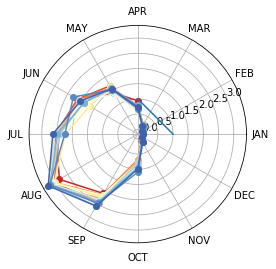

In [7]:
data=west_r_clim.asma()
ax=plt.subplot(1,1,1,projection='polar')
plot_monthly_polar(east_r_a.asma()[::10],ax=ax)
#plot_monthly_polar(east_r_clim.asma(),ax=ax,c="k")
data.shape
ax.plot([0,np.pi/2],[1,1])

In [8]:
f=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/monthprecip/rcp85.nc")
f.variables

{'bounds_time': <cdms2.fvariable.FileVariable at 0x1326222c10>,
 'east': <cdms2.fvariable.FileVariable at 0x1326222d50>,
 'west': <cdms2.fvariable.FileVariable at 0x1326222c50>}

In [9]:
testeast=f("east")

In [10]:
testeast.shape

(28, 1128)

In [11]:
testeast.attributes

{'name': 'variable_612', 'tileIndex': None}

In [14]:
cmip5.models(testeast)

['ACCESS1-0',
 'ACCESS1-3',
 'BNU-ESM',
 'CCSM4',
 'CESM1-CAM5',
 'CMCC-CM',
 'CMCC-CMS',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'CanESM2',
 'FGOALS-g2',
 'GFDL-CM3',
 'GFDL-ESM2G',
 'GFDL-ESM2M',
 'HadGEM2-AO',
 'HadGEM2-CC',
 'HadGEM2-ES',
 'IPSL-CM5A-LR',
 'IPSL-CM5A-MR',
 'IPSL-CM5B-LR',
 'MIROC-ESM',
 'MIROC-ESM-CHEM',
 'MIROC5',
 'MPI-ESM-LR',
 'MPI-ESM-MR',
 'MRI-CGCM3',
 'NorESM1-M',
 'inmcm4']

In [17]:
np.unique([x.split(".")[1] for x in cmip5.models(east_r)])

array(['ACCESS1-0', 'ACCESS1-3', 'BNU-ESM', 'CCSM4', 'CESM1-BGC',
       'CESM1-CAM5', 'CESM1-CAM5-1-FV2', 'CMCC-CM', 'CNRM-CM5',
       'CNRM-CM5-2', 'CSIRO-Mk3-6-0', 'CanESM2', 'FGOALS-g2', 'FGOALS-s2',
       'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2G-1', 'GFDL-ESM2M',
       'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-ES', 'IPSL-CM5A-LR',
       'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC5',
       'MPI-ESM-LR', 'MPI-ESM-MR', 'MPI-ESM-P', 'MRI-CGCM3', 'NorESM1-M',
       'NorESM1-ME', 'bcc-csm1-1', 'bcc-csm1-1-m', 'inmcm4'], dtype='|S16')

In [22]:
east_daily_r=by_month(testeast)
east_daily_r.shape

(28, 94, 12)

In [23]:
monthlymean=east_r[0]
numdays=east_daily_r[0]

In [24]:
cmip5.stop_time(numdays)

2097-7-15 0:0:0.0